# KEN4157 - Reinforcement Learning - Cliff Walking Gymnasium
If you opened this notebook in Google Colab, we recommend to start by saving a copy of the notebook in your own Google Drive, such that you can save any of your changes and experiments.

## Installing & Importing Modules
We will start by installing importing some modules that will likely be useful for your assignment(s). This includes [Gymnasium](https://gymnasium.farama.org/), which is a framework containing many popular RL environments (a successor to the original Gym API from OpenAI).

In [4]:
!pip install gymnasium

import gymnasium as gym
import itertools
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.colors as color


import numpy as np
import seaborn as sns

from tqdm import tqdm

# Make plots look nice
sns.set()
sns.set_context("notebook")
sns.set_style("whitegrid")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.6 MB/s eta 0:00:00


## Setting up the Cliff Walking Environment
Here, we'll set up the Cliff Walking environment, and have a look at how to interact with it according to the Gym API.

**Optional**:
- For a description and documentation of the environment, see: https://gymnasium.farama.org/environments/toy_text/cliff_walking/
- For the implementation of the environment, see: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/cliffwalking.py

In [5]:
env = gym.make('CliffWalking-v0')

action_space = env.action_space
obs_space = env.observation_space
print(f"Action space: {action_space}")
print(f"Observation space: {obs_space}")

# We'll define a few strings here, because proper names are sometimes nicer
# to work with (print) than arbitrary indices
ACTION_NAMES = ["Move Up", "Move Right", "Move Down", "Move Left"]

print(f"There are {action_space.n} different actions in this environment.")
for i in range(action_space.n):
  print(f"Action {i} = {ACTION_NAMES[i]}")
print(f"There are {obs_space.n} discrete states in this environment.")

Action space: Discrete(4)
Observation space: Discrete(48)
There are 4 different actions in this environment.
Action 0 = Move Up
Action 1 = Move Right
Action 2 = Move Down
Action 3 = Move Left
There are 48 discrete states in this environment.


## Visualisation Code
Some functions here that let us nicely visualise Q-value tables for the Cliff Walking environment. No need to touch any of this, but you should run the code block, such that you can use the functions later on.

In [6]:
# Thanks to: https://stackoverflow.com/a/66050636/6735980
def triangulation_for_triheatmap(num_cols, num_rows):
    xv, yv = np.meshgrid(np.arange(-0.5, num_cols), np.arange(-0.5, num_rows))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, num_cols), np.arange(0, num_rows))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (num_cols + 1) * (num_rows + 1)  # indices of the centers

    trianglesN = [(i + j * (num_cols + 1), i + 1 + j * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    trianglesE = [(i + 1 + j * (num_cols + 1), i + 1 + (j + 1) * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    trianglesS = [(i + 1 + (j + 1) * (num_cols + 1), i + (j + 1) * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    trianglesW = [(i + (j + 1) * (num_cols + 1), i + j * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    return [tri.Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]

# Thanks to: https://stackoverflow.com/a/66050636/6735980
def create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left):
    NUM_COLS = 12
    NUM_ROWS = 4

    values = [q_vals_up , q_vals_right, q_vals_down, q_vals_left]
    triangul = triangulation_for_triheatmap(NUM_COLS, NUM_ROWS)
    fig, ax = plt.subplots()

    imgs = [ax.tripcolor(t, val.ravel(), cmap='RdYlGn',
                        norm=color.SymLogNorm(linthresh=20.0, linscale=1.0,
                                               vmin=np.min(values),
                                               vmax=np.max(values), base=10)
                        )
            for t, val in zip(triangul, values)]
    cbar = fig.colorbar(imgs[0] , ax=ax)

    ax.set_xticks(range(NUM_COLS))
    ax.set_yticks(range(NUM_ROWS))
    ax.invert_yaxis()
    ax.margins(x=0, y=0)
    ax.set_aspect('equal', 'box')  # square cells
    plt.tight_layout()
    plt.show()

def plot_returns_per_episode(returns_per_episode):
    fig, ax = plt.subplots()
    plt.plot([episode for episode in range(len(returns_per_episode))], returns_per_episode, label="Returns per Episode")
    ax.set_xlabel("Episode")
    ax.set_ylabel(f"Returns")
    ax.legend()
    plt.show()


## Random Value Function & Policy
In the below code block, we'll:
- fill up a Q(s, a) table with completely random numbers
- run through a bunch of steps with a random policy
- demonstrate how the above functions can be used to visualise this random Q-table and policy

Afterwards, you can implement your own (non-random) algorithms and use the plotting functions in the same way.

100%|██████████| 100000/100000 [00:02<00:00, 37334.28it/s]


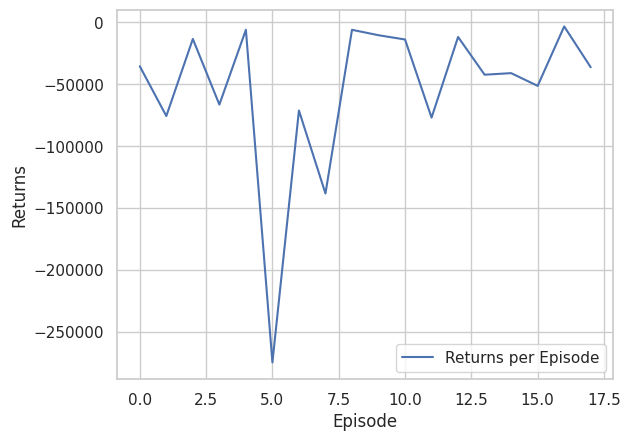

<ipython-input-6-1c7614a9f92d>:34: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  cbar = fig.colorbar(imgs[0] , ax=ax)


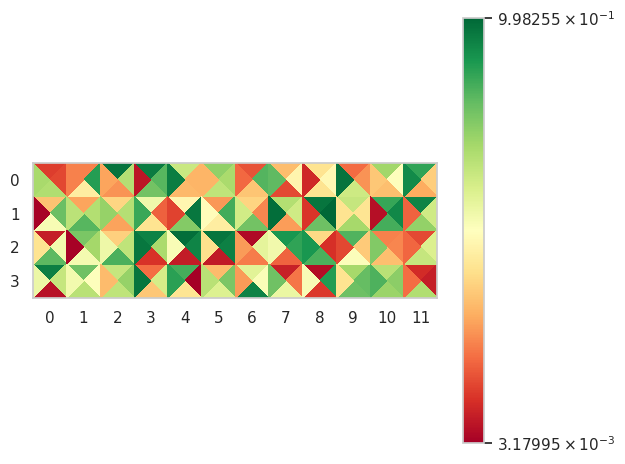

In [7]:
random_q_table = np.random.random((obs_space.n, action_space.n))
returns_per_episode = []

observation, info = env.reset()
current_episode_returns = 0.0

for step in tqdm(range(100_000)):
    action = action_space.sample()

    new_obs, reward, terminated, truncated, info = env.step(action)
    current_episode_returns = current_episode_returns + reward

    if terminated or truncated:
        # episode ended: store data and reset to new episode
        returns_per_episode.append(current_episode_returns)
        current_episode_returns = 0.0
        observation, info = env.reset()
    else:
        observation = new_obs

# Plot returns we got for each completed episode
plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table (which in this case is just random numbers)
q_vals_up = random_q_table[:, 0]
q_vals_right = random_q_table[:, 1]
q_vals_down = random_q_table[:, 2]
q_vals_left = random_q_table[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

## Your Code
Your own code should probably go below here!

# Q learning

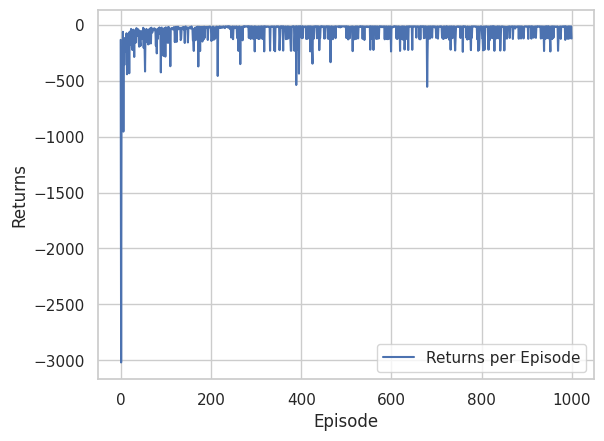

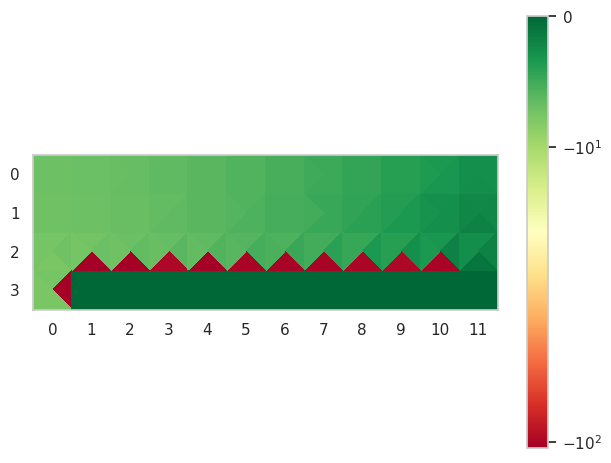

In [8]:
# Parameters for Q-learning
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
num_episodes = 1000  # Number of episodes for training
epsilon = 0.1  # Exploration rate


# Function to choose an action always exploiting the learned values
# Function to choose an action using epsilon-greedy policy
def choose_action(state):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore action space
    else:
        return np.argmax(random_q_table[state])  # Exploit learned values

# Q-learning algorithm
random_q_table = np.zeros((obs_space.n, action_space.n))
returns_per_episode = []  # To store total rewards per episode

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0

    while not done:
        action = choose_action(state)
        next_state, reward, done, truncated, info = env.step(action)

        # Q-learning update
        old_value = random_q_table[state, action]
        next_max = np.max(random_q_table[next_state])

        new_value = old_value + alpha * (reward + gamma * next_max - old_value)
        random_q_table[state, action] = new_value

        total_rewards += reward
        state = next_state

    returns_per_episode.append(total_rewards)


plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table
q_vals_up = random_q_table[:, 0]
q_vals_right = random_q_table[:, 1]
q_vals_down = random_q_table[:, 2]
q_vals_left = random_q_table[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

# SARSA with epsilon-greedy policy

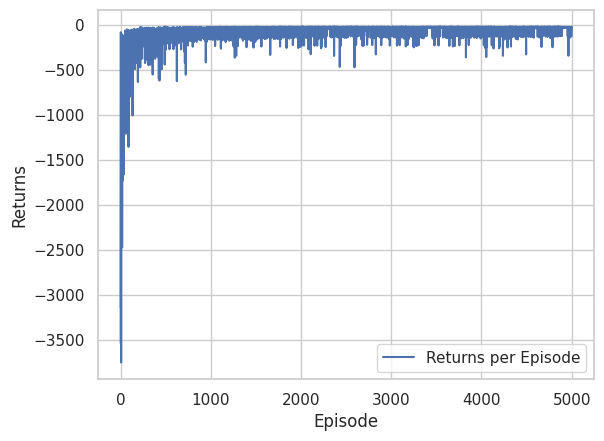

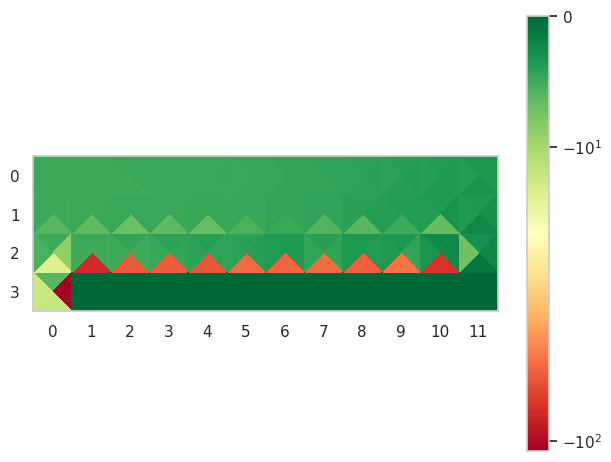

In [9]:
# Parameters for SARSA
alpha = 0.01  # Learning rate
gamma = 0.8  # Discount factor
epsilon = 0.3  # Exploration rate
num_episodes = 5000  # Number of episodes for training

# Function to choose an action using epsilon-greedy policy
def choose_action(state):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore action space
    else:
        return np.argmax(random_q_table[state])  # Exploit learned values

# SARSA algorithm
random_q_table = np.zeros((obs_space.n, action_space.n))
returns_per_episode = []  # To store total rewards per episode

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0
    action = choose_action(state)
    while not done:

        next_state, reward, done, truncated, info = env.step(action)
        next_action = choose_action(next_state)
        # SARSA update

        old_value = random_q_table[state, action]

        new_value = old_value + alpha * (reward + gamma * random_q_table[next_state, next_action] - old_value)
        random_q_table[state, action] = new_value

        total_rewards += reward
        state = next_state
        action = next_action

    returns_per_episode.append(total_rewards)


plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table
q_vals_up = random_q_table[:, 0]
q_vals_right = random_q_table[:, 1]
q_vals_down = random_q_table[:, 2]
q_vals_left = random_q_table[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)


# SARSA with boltzmann policy

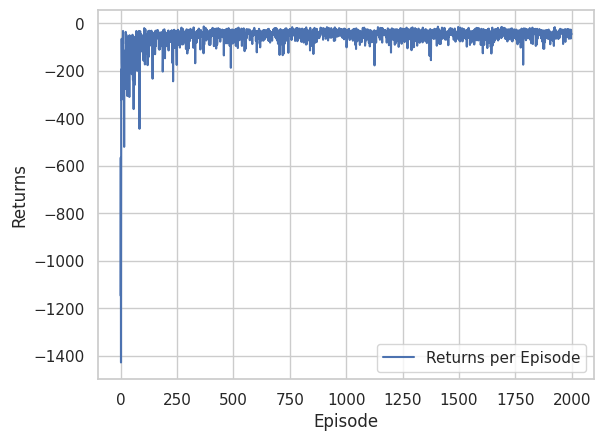

[[ -9.70307425  -9.57240034  -9.67045461  -9.66985253]
 [ -9.51471628  -9.31011901  -9.57105946  -9.70789166]
 [ -9.33889152  -9.06543055  -9.30767003  -9.60015321]
 [ -8.98149773  -8.67959931  -8.92255562  -9.37917961]
 [ -8.60931765  -8.32165695  -8.47655643  -9.02459565]
 [ -8.29881978  -7.876176    -8.03661588  -8.6472113 ]
 [ -7.68761827  -7.29168745  -7.5166054   -8.53732432]
 [ -7.19732037  -6.67393469  -6.89928071  -7.78847078]
 [ -6.63808309  -6.1466395   -6.00597488  -7.20710488]
 [ -6.09175738  -5.35823455  -5.30469082  -6.53402814]
 [ -5.45071551  -4.90942945  -4.33220617  -5.90766526]
 [ -4.822719    -4.72994828  -3.74211918  -5.3563205 ]
 [ -9.7135658   -9.51232225  -9.68871375  -9.67490852]
 [ -9.56561991  -9.27007659  -9.50045228  -9.67370178]
 [ -9.47112622  -9.04463171  -9.22990455  -9.51927443]
 [ -9.02007188  -8.58871901  -8.90415396  -9.30398347]
 [ -8.68204811  -8.18713836  -8.46264946  -8.96729821]
 [ -8.38915621  -7.61523299  -7.91891038  -8.48535079]
 [ -7.7738

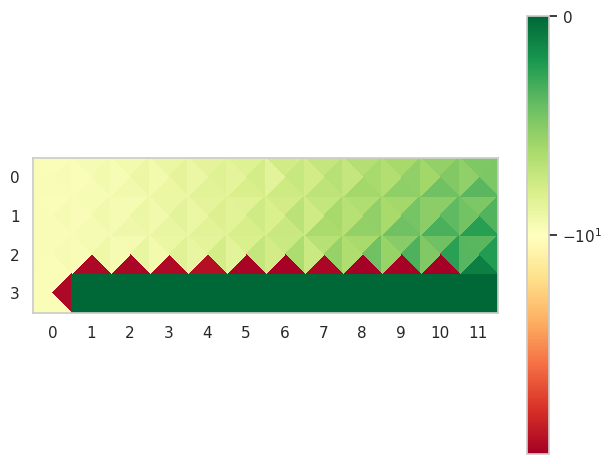

In [10]:
# Parameters for SARSA
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
num_episodes = 2000  # Number of episodes for training
temperature = 1  # Temperature for boltzmann policy

# Function to choose an action using boltzmann policy
def choose_action(state):
    q_values = random_q_table[state]
    probabilities = np.exp(q_values / temperature) / np.sum(np.exp(q_values / temperature))
    return np.random.choice(np.arange(len(q_values)), p=probabilities)


# SARSA algorithm
random_q_table = np.zeros((obs_space.n, action_space.n))
returns_per_episode = []  # To store total rewards per episode

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0
    action = choose_action(state)
    while not done:

        next_state, reward, done, truncated, info = env.step(action)
        next_action = choose_action(next_state)
        # SARSA update

        old_value = random_q_table[state, action]

        new_value = old_value + alpha * (reward + gamma * random_q_table[next_state, next_action] - old_value)
        random_q_table[state, action] = new_value

        total_rewards += reward
        state = next_state
        action = next_action

    returns_per_episode.append(total_rewards)


plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table
print(random_q_table)
q_vals_up = random_q_table[:, 0]
q_vals_right = random_q_table[:, 1]
q_vals_down = random_q_table[:, 2]
q_vals_left = random_q_table[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)


# Generalised True online TD-lambda

followed algo in: [Sutton & Barto](https://lcalem.github.io/blog/2019/02/25/sutton-chap12#125-true-online-td-lambda )

Episode 0: Total rewards = -10600


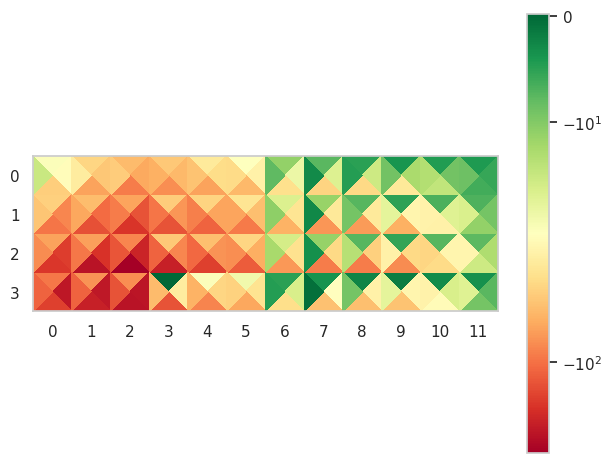

Episode 800: Total rewards = -4130


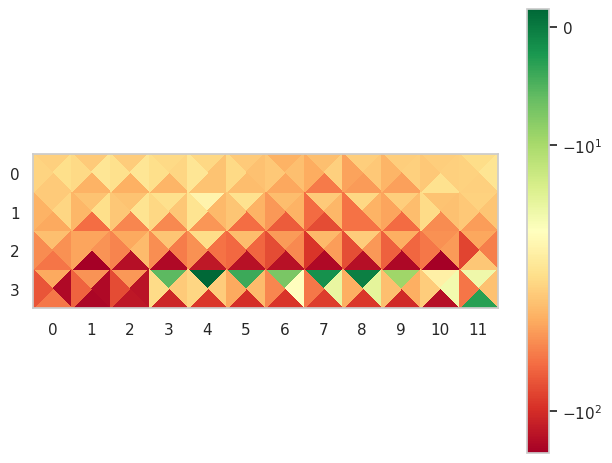

Episode 1600: Total rewards = -341


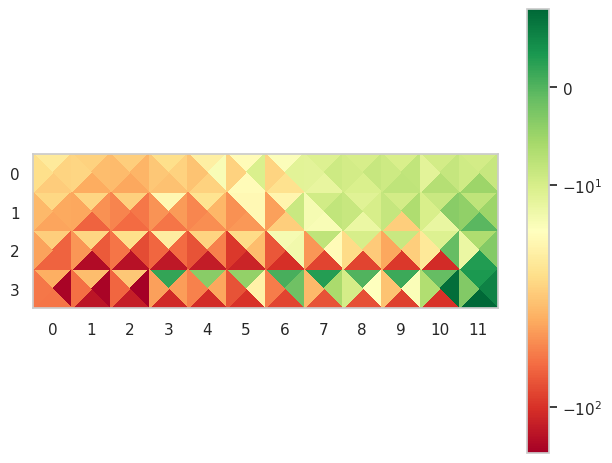

Episode 2400: Total rewards = -43


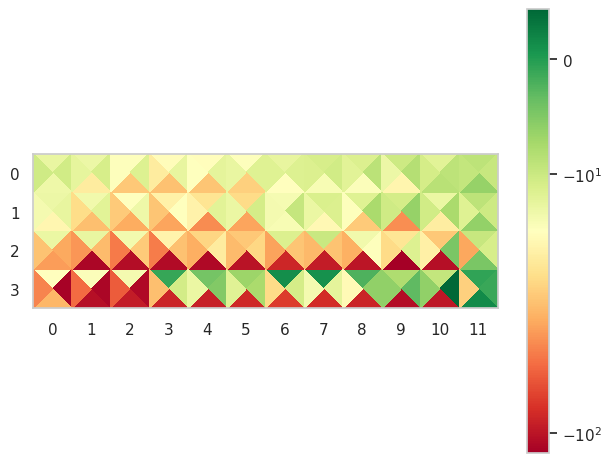

Episode 3200: Total rewards = -38


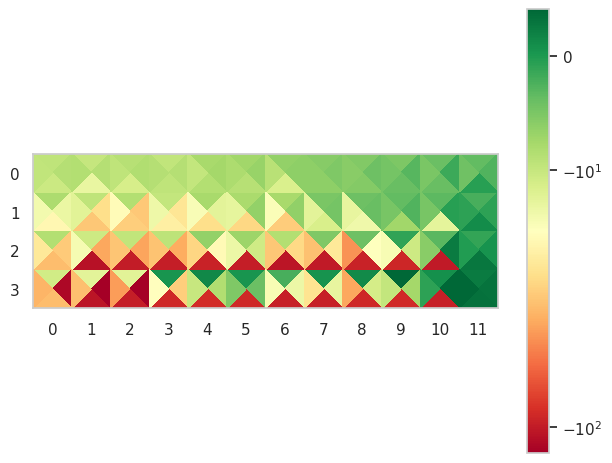

reward graph


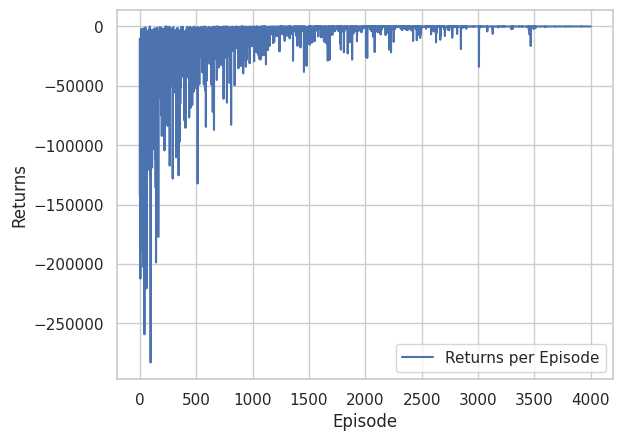

Episode 4000: Total rewards = -25


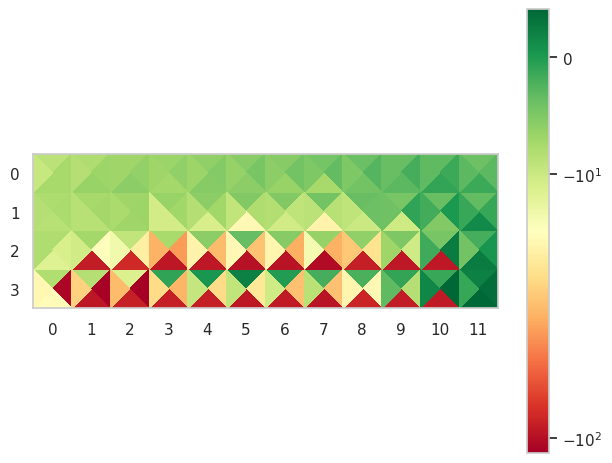

In [21]:
from os import wait
import numpy as np

# Epsilon-greedy policy for action selection
def epsilon_greedy_policy(state, w, num_actions, env, epsilon):
    """
    Select an action using an epsilon-greedy policy based on current state.

    :param state: The current state.
    :param w: The weight vector for the value function.
    :param num_actions: The number of possible actions.
    :param env: The environment, used to check action space if necessary.
    :param epsilon: The probability of choosing a random action.
    :return: The selected action.
    """
    q_values = np.zeros(num_actions)
    for action in range(num_actions):
        feature_vector = get_feature_vector(state, action, False)  # Assume non-terminal for action-value computation
        q_values[action] = np.dot(w.T, feature_vector)

    if np.random.rand() < epsilon:
        # Exploration: Randomly select an action
        action = np.random.choice(num_actions)
    else:
        # Exploitation: Select the action with the maximum Q-value
        action = np.argmax(q_values)

    return action


def calc_v(w):
  V = []
  for row in range(nrows):
    for col in range(ncols):
        state_index = row * ncols + col  # Convert 2D grid coordinates to linear index
        # print(state_index)
        # Calculate the action value for each action and find the maximum
        action_values = []
        for action in range(num_actions):
            feature_vector = get_feature_vector(state_index, action, False)
            action_value = np.dot(w.T, feature_vector)
            action_values.append(action_value)

        # Store the maximum action value in the value function grid
        V.append(action_values)
  return np.array(V)


def initialize_tiles(ncols, nrows, tilewidth, tileheight):
    # Create a dictionary to map from state indices to tile indices
    tile_dict = {}
    # Adjusted loop to create overlaps according to the specified range
    for row in range(nrows):
        for col in range(ncols):
            # Find the tiles that this state belongs to
            covered_tiles = []
            # Check tiles starting within a range that they could cover this state
            # Tiles can start earlier than the current row/col, but not later than the current row/col
            min_row_start = max(0, row - tileheight + 1)
            max_row_start = row
            min_col_start = max(0, col - tilewidth + 1)
            max_col_start = col

            for start_row in range(min_row_start, max_row_start + 1):
                for start_col in range(min_col_start, max_col_start + 1):
                    # Calculate the tile index based on its top-left corner
                    tile_index = start_row * ncols + start_col
                    covered_tiles.append(tile_index)
            # State index (assuming row-major order)
            state_index = row * ncols + col
            # Map the state index to the tile indices that cover it
            tile_dict[state_index] = covered_tiles
    return tile_dict


def get_feature_vector(state, action, is_terminal):
    """ Efficient feature vector computation using precomputed tile indices. """
    feature_vector = np.zeros(num_tiles * num_actions)
    # if state == 47 or is_terminal:
    #     return feature_vector

    # Access the precomputed tile indices for this state
    active_tiles = tile_dict[state]
    for tile_index in active_tiles:
        feature_vector_index = tile_index * num_actions + action
        feature_vector[feature_vector_index] = 1
    return feature_vector


# Parameters for TD(lambda)
alpha = 0.05  # Learning rate
gamma = 0.90  # Discount factor
num_episodes = 4000  # Number of episodes for training
epsilon_start  = 1.0  # Epsilon for epsilon-greedy policy
epsilon_min = 0.05   # Minimum epsilon value
lambda_val = 0.8  # Lambda value for TD(lambda)
epsilon_decay = (epsilon_start - epsilon_min) / num_episodes


# Initialise tile encoding
num_actions = env.action_space.n
num_states = env.observation_space.n
tilewidth = 3
tileheight = 3
ncols = 12  # Number of columns in the environment
nrows = 4   # Number of rows in the environment
tile_dict = initialize_tiles(ncols, nrows, tilewidth, tileheight)
num_tiles = len(tile_dict)


# Initialize value-function weights, eligibility trace
w = np.zeros(num_tiles * num_actions)  # Linear weight vector
returns_per_episode = []  # To store total rewards per episode


# True Online TD(λ)
for episode in range(num_episodes):
    done = False
    state, _ = env.reset()
    z = np.zeros(num_tiles * num_actions)  # Eligibility trace vector
    V_old = 0
    total_rewards = 0
    epsilon = max(epsilon_min, epsilon_start - episode * epsilon_decay)  # Update epsilon with decay


    while not done:
        action = epsilon_greedy_policy(state, w, num_actions, env, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        next_action = epsilon_greedy_policy(next_state, w, num_actions, env, epsilon)

        x = get_feature_vector(state, action, done)
        x_prime = get_feature_vector(next_state, next_action, done)

        # Compute values
        V = np.dot(w.T, x)
        V_prime = np.dot(w.T, x_prime)
        delta = reward + gamma * V_prime - V

        # Update traces and weights
        z = gamma * lambda_val * z + (1 - alpha * gamma * lambda_val * np.dot(z.T, x)) * x
        w = w + alpha * (delta + V - V_old) * z - alpha * (V - V_old) * x
        V_old = V_prime
        x = x_prime

        # Update state
        state = next_state
        total_rewards += reward


    if episode % (num_episodes/5) == 0:
        print(f"Episode {episode}: Total rewards = {total_rewards}")
        # Plot heatmap from our Q-table
        Q = calc_v(w)
        q_vals = {
            'up': Q[:, 0],
            'right': Q[:, 1],
            'down': Q[:, 2],
            'left': Q[:, 3]
        }
        create_qvals_heatmap(q_vals['up'], q_vals['right'], q_vals['down'], q_vals['left'])
    returns_per_episode.append(total_rewards)


# Final plots
print(f"reward graph")
plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table
print(f"Episode {episode+1}: Total rewards = {total_rewards}")
Q = calc_v(w)
q_vals = {
    'up': Q[:, 0],
    'right': Q[:, 1],
    'down': Q[:, 2],
    'left': Q[:, 3]
}
create_qvals_heatmap(q_vals['up'], q_vals['right'], q_vals['down'], q_vals['left'])